**Автор: Анна Смелова**

## Курсовая работа по теме "Classification. Choose tutors" (Часть 1: Logistic Regression)
#### Geekbrains Algorithms for analyze data. Choose proper tutors for math exam
https://www.kaggle.com/c/classification-choose-tutors

**Материалы к проекту (файлы):**
train.csv, 
test.csv

**Задание:**
Предсказать вероятность того, подойдет ли репетитор для подготовки к экзамену по математике.

**Целевая переменная:**
choose

**Основная метрика:**
The evaluation metric is ROC AUC

**Пороговое значение метрики:**
logistic_regression 0.66965

**Ограничения:**
You can only use these imports:<br>
<font color='green'>
import numpy as np<br>
import pandas as pd<br>
from sklearn.model_selection import train_test_split<br>
from imblearn import over_sampling, under_sampling<br>
import matplotlib.pyplot as plt<br>
import seaborn as sns<br></font>

**В этой части курсовой работы будем использовать модель логистической регрессии для предсказания.**

## Шаг 1: Подготовка инструментов

### 1.1 Необходимые модули

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn import over_sampling, under_sampling
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1.2 Загрузка данных

Загрузим тренировочные данные в переменную **train_data**, тестовые данные в переменную **test_data**

In [2]:
train_data_base=pd.read_csv('classification-choose-tutors/train.csv')
train_data=train_data_base.copy()
train_data.shape

(10000, 13)

In [3]:
test_data_base=pd.read_csv('classification-choose-tutors/test.csv')
test_data=test_data_base.copy()
test_data.shape

(10000, 12)

### 1.3 Необходимые классы и функции

Функция для расчета основной метрики

In [4]:
from numpy import trapz  # используем эту функцию для расчета площади под кривой

def calc_roc_auc(y_pred, y):
    TP, FP, FN, TN = 0, 0, 0, 0
    l = len(y_pred)
    for i in range(l):
        if y_pred[i] == 1 and y[i] == 1:
            TP += 1
        elif y_pred[i] == 1 and y[i] == 0:
            FP += 1
        elif y_pred[i] == 0 and y[i] == 0:
            TN += 1
        elif y_pred[i] == 0 and y[i] == 1:
            FN += 1
            
    FPR = FP / (FP + TN)
    
    TPR = TP / (TP + FN)
    
    AUC_ROC = trapz([0,TPR,1], x = [0,FPR,1], dx=0.1)
    
    return AUC_ROC

Функция для подсчета точности как доли правильных ответов

In [5]:
def get_accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(predicted)):
        if (predicted[i] > 0.5): 
            predicted[i] = 1
        elif (predicted[i] <= 0.5):
            predicted[i] = 0
    
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [6]:
def plot_boxplot(title, train_data, test_data):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.box(True)
    plt.grid()
    my_pal = {'Train': 'LightGreen', 'Test': 'LightYellow'}
    df = pd.DataFrame({'Train' : train_data, 'Test' : test_data})
    sns.boxplot(x='value', y='variable', data=pd.melt(df), palette=my_pal)
    plt.show()

In [7]:
def plot_hist(title, train_data, test_data):
    plt.figure(figsize=(10,5))
    plt.xlabel(title)
    plt.grid()
    plt.hist(train_data, bins=15, density=False, label='Train', alpha=0.5, color='green')
    plt.hist(test_data, bins=15, density=False, label='Test', alpha=0.5, color='yellow')
    plt.legend()
    plt.show()

Класс для логистической регрессии

In [8]:
class LogisticRegression:
    
    def __init__(self, eta=0.01, max_iter = 1e5, reg_type = 'l2', reg = 1e-8):
        self.w = []
        self.losses = []
        self.eta = eta
        self.max_iter = max_iter
        self.reg_type = reg_type
        self.reg = reg
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def log_loss(self, X, y):
        m = X.shape[0]
        # используем функцию сигмоиды, написанную ранее
        A = self.sigmoid(np.dot(X, self.w))

        # for labels 0, 1
        loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))

        # for labels -1, 1
        # temp_y = np.where(y == 1, 1, -1)
        # loss = 1.0 / m * np.sum(np.log(1 + np.exp(-temp_y * np.dot(X, w))))

        grad = 1.0 / m * X.T @ (A - y)

        return loss, grad
    
    # Реализуем градиентный спуск
    def optimize(self, X, y, n_iterations):
        # потери будем записывать в список для отображения в виде графика
        losses = []

        for i in range(n_iterations):        
            loss, grad = self.log_loss(X, y)
            # Регуляризация
            if self.reg_type == 'l2':
                dReg = self.reg * self.w # градиент регуляризации
            else:
                dReg = self.reg * np.sign(self.w)
            #
            self.w = self.w - self.eta * grad

            losses.append(loss)

        return self.w, losses
    
    def fit(self, X, y):
        X=np.append(X, np.ones((X.shape[0],1)),1)
        # иницилизируем начальный вектор весов
        self.w = np.zeros(X.shape[1])
        n_iterations = self.max_iter
        
        w, losses = self.optimize(X, y, n_iterations)
        
        self.w = w
        self.losses = losses
        
        return self
        
    
    def predict(self, X):
        X=np.append(X, np.ones((X.shape[0],1)),1)
        m = X.shape[0]

        y_predicted = np.zeros(m)

        A = np.squeeze(self.sigmoid(np.dot(X, self.w)))

        # За порог отнесения к тому или иному классу примем вероятность 0.5
        for i in range(A.shape[0]):
            if (A[i] > 0.5): 
                y_predicted[i] = 1
            elif (A[i] <= 0.5):
                y_predicted[i] = 0

        #return y_predicted
        return A

**Проверка модели на синтетических данных**

In [9]:
from sklearn.datasets import make_classification
classification_data, classification_labels = make_classification(n_samples=300, n_features=7, n_informative=5, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=9)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(classification_data, classification_labels, test_size=0.3, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(210, 7) (90, 7) (210,) (90,)


In [11]:
%%time
n_iterations = 100000
eta = 1
lr = LogisticRegression(eta=eta, max_iter=n_iterations)
lr.fit(X_train, y_train)
test_labels = lr.predict(X_valid)
train_labels = lr.predict(X_train)
# Точность на обучающей выборке
train_accuracy = get_accuracy_metric(y_train, train_labels)
# Точность на тестовой выборке
test_accuracy = get_accuracy_metric(y_valid, test_labels)

print(f'Train Accuracy {train_accuracy}')
print(f'Test Accuracy {test_accuracy}')
print()
print(f'Train ROC_AUC {calc_roc_auc(train_labels, y_train)}')
print(f'Test ROC_AUC {calc_roc_auc(test_labels, y_valid)}')

/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


Train Accuracy 100.0
Test Accuracy 98.88888888888889

Train ROC_AUC 1.0
Test ROC_AUC 0.9895833333333333
CPU times: user 7.27 s, sys: 64.2 ms, total: 7.33 s
Wall time: 9.03 s


## Шаг 2: Подготовка данных

In [12]:
train_data.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [13]:
test_data.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
3,10003,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0
4,10004,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0


### 2.1 Обработка пропущенных значений и выбросов в данных

In [14]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,4999.5000,2886.895680,0.0,2499.75,4999.5,7499.25,9999.0
age,10000.0,45.8009,8.030274,23.0,40.00,46.0,51.00,68.0
years_of_experience,10000.0,1.9748,1.766883,0.0,0.00,2.0,3.00,9.0
lesson_price,10000.0,1702.4400,523.789062,200.0,1300.00,1550.0,2150.00,3950.0
qualification,10000.0,1.7243,0.798845,1.0,1.00,2.0,2.00,4.0
physics,10000.0,0.3706,0.482990,0.0,0.00,0.0,1.00,1.0
chemistry,10000.0,0.1215,0.326724,0.0,0.00,0.0,0.00,1.0
biology,10000.0,0.1172,0.321675,0.0,0.00,0.0,0.00,1.0
english,10000.0,0.0591,0.235824,0.0,0.00,0.0,0.00,1.0
geography,10000.0,0.0277,0.164120,0.0,0.00,0.0,0.00,1.0


In [15]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,14999.5000,2886.895680,10000.0,12499.75,14999.5,17499.25,19999.0
age,10000.0,45.9245,8.031977,23.0,41.00,46.0,51.00,68.0
years_of_experience,10000.0,1.9857,1.771217,0.0,0.00,2.0,3.00,9.0
lesson_price,10000.0,1699.9100,526.260094,300.0,1300.00,1550.0,2150.00,3950.0
qualification,10000.0,1.7023,0.789644,1.0,1.00,1.5,2.00,4.0
physics,10000.0,0.3721,0.483389,0.0,0.00,0.0,1.00,1.0
chemistry,10000.0,0.1281,0.334218,0.0,0.00,0.0,0.00,1.0
biology,10000.0,0.1158,0.320001,0.0,0.00,0.0,0.00,1.0
english,10000.0,0.0490,0.215879,0.0,0.00,0.0,0.00,1.0
geography,10000.0,0.0292,0.168375,0.0,0.00,0.0,0.00,1.0


Пропусков в данных нет.<br>
Выбросов в данных также не видно. Но, на всякий случай посмотрим более детально на признак "lesson_price".

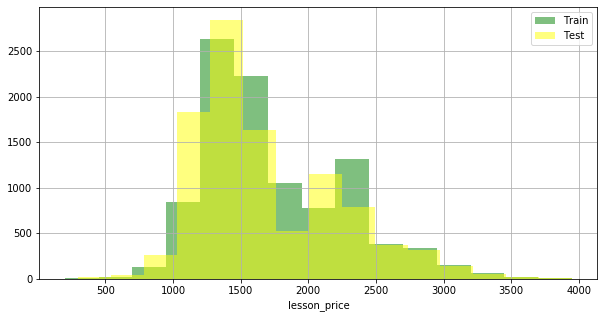

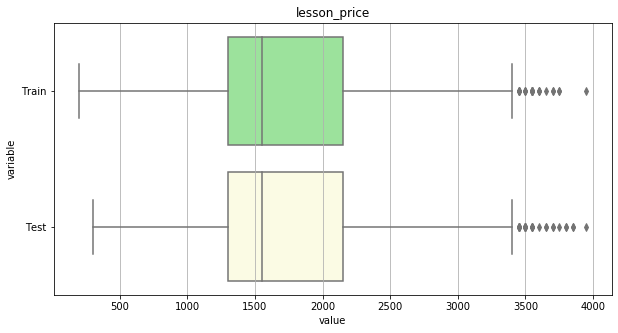

In [16]:
plot_hist('lesson_price', train_data['lesson_price'], test_data['lesson_price'])
plot_boxplot('lesson_price', train_data['lesson_price'], test_data['lesson_price'])

Значения, которые превышают 3400 можно считать выбросами. Но, так как они есть и в тренировочной выборке и в тестовой, не будем удалять их.

### 2.2 Поиск взаимосвязей между признаками

Разделим признаки на количественные, ранговые и категориальные (признак "Id" пока добавим в ранговые, а потом уберем, т.к. он неинформативный, признак "age" добавим в количественные):

In [17]:
cat_features = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'choose']
rank_features = ['Id', 'years_of_experience', 'qualification']
num_features = ['age', 'lesson_price', 'mean_exam_points']

In [18]:
train_data_num = train_data[num_features]
train_data_rank = train_data[rank_features]
train_data_cat = train_data[cat_features]

test_data_num = test_data[num_features]
test_data_rank = test_data[rank_features]
test_data_cat = test_data[cat_features[:-1]]

Для количественных признаков посмотрим на матрицу корреляции.

In [19]:
corr_features = num_features + ['choose']
corr = train_data[corr_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,lesson_price,mean_exam_points,choose
age,1,0.00069,0.0041,0.017
lesson_price,0.00069,1,0.73,-0.13
mean_exam_points,0.0041,0.73,1,0.11
choose,0.017,-0.13,0.11,1


Признаки "lesson_price" и "mean_exam_points" высоко коррелируют между собой, но недостаточно, чтобы удалить один из них.

Для категориальных и ранговых признаков псмотрим на взаимную информацию между признаками и целевой переменной.<br>
Сначала разделим признаки тренировочной выборки на непосредственно признаки и на целевую переменную. Признак "Id" неинформативный - тоже выделим его в отдельную переменную.

In [20]:
target = train_data_cat['choose']
train_ids = train_data_rank['Id'].astype('int64')
train_num = train_data_num
train_rank = train_data_rank.drop(['Id'],axis=1)
train_cat = train_data_cat.drop(['choose'],axis=1)

Для подсчета взаимной информации надо, чтобы признак был дискретным.

In [21]:
from sklearn.metrics.cluster import contingency_matrix
def get_mi(x, y):
    mi = 0
    cm = contingency_matrix(y, x)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            size = np.sum(cm)
            p_x_y = cm[i][j] / size
            p_x = np.sum(cm[:, j]) / size
            p_y = np.sum(cm[i]) / size

            if p_x_y == 0:
                continue
            mi += p_x_y * np.log(p_x_y / (p_x * p_y))
    return mi

In [22]:
for cat in train_cat.columns:
    print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_cat[cat], target)}')

Взаимная информация признака physics с целевой переменной 0.018310514044706433
Взаимная информация признака chemistry с целевой переменной 0.0036711220021946444
Взаимная информация признака biology с целевой переменной 0.0022637017162383385
Взаимная информация признака english с целевой переменной 0.0002319468679485839
Взаимная информация признака geography с целевой переменной 1.9682676972689636e-05
Взаимная информация признака history с целевой переменной 1.1370782112761783e-05


In [23]:
for cat in train_rank.columns:
    print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_rank[cat], target)}')

Взаимная информация признака years_of_experience с целевой переменной 0.0011498680108282845
Взаимная информация признака qualification с целевой переменной 0.0013668439216665876


Одномерный отбор не показал особой "силы" категориальных и ранговых признаков.

### 2.3 Добавление новых признаков

#### 2.3.1 Суммарное количество предметов помимо математики у преподавателя

In [24]:
train_subjects = train_data[['physics','chemistry','biology','english','geography','history']].sum(axis=1) 
train_data['subjects_num'] = train_subjects

test_subjects = test_data[['physics','chemistry','biology','english','geography','history']].sum(axis=1) 
test_data['subjects_num'] = test_subjects

rank_features.append('subjects_num') # это ранговый признак

print(train_data['subjects_num'].value_counts())

0.0    4381
1.0    4252
2.0    1216
3.0     147
4.0       4
Name: subjects_num, dtype: int64


#### 2.3.2 Скорость достижения квалификации

In [25]:
train_qual_speed = train_data['qualification'] / train_data['age']
train_data['qual_speed'] = train_qual_speed

test_qual_speed = test_data['qualification'] / test_data['age']
test_data['qual_speed'] = test_qual_speed

num_features.append('qual_speed') # это количественный признак

Снова посмотрим на взаимосвязи между признаками.

In [26]:
corr_features = num_features + ['choose']
corr = train_data[corr_features].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,lesson_price,mean_exam_points,qual_speed,choose
age,1,0.00069,0.0041,-0.37,0.017
lesson_price,0.00069,1,0.73,0.72,-0.13
mean_exam_points,0.0041,0.73,1,0.69,0.11
qual_speed,-0.37,0.72,0.69,1,0.029
choose,0.017,-0.13,0.11,0.029,1


In [27]:
for cat in cat_features:
    if cat != 'choose':
        print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_data[cat], target)}')

Взаимная информация признака physics с целевой переменной 0.018310514044706433
Взаимная информация признака chemistry с целевой переменной 0.0036711220021946444
Взаимная информация признака biology с целевой переменной 0.0022637017162383385
Взаимная информация признака english с целевой переменной 0.0002319468679485839
Взаимная информация признака geography с целевой переменной 1.9682676972689636e-05
Взаимная информация признака history с целевой переменной 1.1370782112761783e-05


In [28]:
for cat in rank_features:
    if cat!='Id':
        print(f'Взаимная информация признака {cat} с целевой переменной {get_mi(train_data[cat], target)}')

Взаимная информация признака years_of_experience с целевой переменной 0.0011498680108282845
Взаимная информация признака qualification с целевой переменной 0.0013668439216665876
Взаимная информация признака subjects_num с целевой переменной 0.021435503006294005


Получилось, что у признака "subjects_num" и признака "physics" самая высокая взаимная информация. Удалим признаки "chemistry", "biology", "english", "geography" и "history" как неинформативные.

In [29]:
cat_features = ['physics']
rank_features = ['years_of_experience', 'qualification', 'subjects_num']
num_features = ['age', 'lesson_price', 'mean_exam_points', 'qual_speed']
target_feature = 'choose'
id_feature = 'Id'

In [30]:
train_num = train_data[num_features]
train_rank = train_data[rank_features]
train_cat = train_data[cat_features]
target = train_data[target_feature]
train_ids = train_data[id_feature]

test_num = test_data[num_features]
test_rank = test_data[rank_features]
test_cat = test_data[cat_features]
test_ids = test_data[id_feature]

### 2.4 Масштабирование признаков

Все категориальные признаки представляют из себя наборы из 0 и 1.

In [31]:
train_cat.describe()

,physics
count,10000.00000
mean,0.37060
std,0.48299
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


Всем ранговым признакам поставим в соответствие наборы из 0 и 1, используя для этого dummy-переменные:

In [32]:
for feature in train_rank.columns:
    train_rank[feature] = train_rank[feature].astype(object)
train_rank = pd.get_dummies(train_rank)
    
for feature in test_rank.columns:
    test_rank[feature] = test_rank[feature].astype(object)
test_rank = pd.get_dummies(test_rank)

print(train_rank.shape, test_rank.shape)

(10000, 19) (10000, 19)


/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/annasmelova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
# Проверим, что полученные признаки совпадают
print(train_rank.columns == test_rank.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


In [34]:
train_rank.describe()

,years_of_experience_0.0,years_of_experience_1.0,years_of_experience_2.0,years_of_experience_3.0,years_of_experience_4.0,years_of_experience_5.0,years_of_experience_6.0,years_of_experience_7.0,years_of_experience_8.0,years_of_experience_9.0,qualification_1.0,qualification_2.0,qualification_3.0,qualification_4.0,subjects_num_0.0,subjects_num_1.0,subjects_num_2.0,subjects_num_3.0,subjects_num_4.0
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.277400,0.184200,0.174300,0.154500,0.117700,0.058100,0.023400,0.007300,0.002200,0.000900,0.489100,0.303300,0.201800,0.00580,0.438100,0.425200,0.12160,0.014700,0.000400
std,0.447738,0.387667,0.379386,0.361445,0.322269,0.233944,0.151178,0.085132,0.046855,0.029988,0.499906,0.459707,0.401364,0.07594,0.496178,0.494398,0.32684,0.120355,0.019997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000


Отмасштабируем получившиеся количественные признаки методом нормализации.

In [35]:
# TRAIN
train_num_min = np.min(train_num, axis=0)
train_num_max = np.max(train_num, axis=0)

# TEST
test_num_min = np.min(test_num, axis=0)
test_num_max = np.max(test_num, axis=0)

#display(train_num_min, test_num_min, train_num_max, test_num_max)

In [36]:
train_num_d = train_num_max - train_num_min
test_num_d = test_num_max - test_num_min

train_num_norm = train_num.to_numpy(copy='True')
test_num_norm = test_num.to_numpy(copy='True')

# вычтем из каждого значения признака минимум и поделим на разность между максимумом и минимумом
for i in range(train_num_norm.shape[0]):
    for j in range(train_num_norm.shape[1]):
        train_num_norm[i][j] = (train_num_norm[i][j] - train_num_min[j]) / train_num_d[j]
        
for k in range(test_num_norm.shape[0]):
    for m in range(test_num_norm.shape[1]):
        test_num_norm[k][m] = (test_num_norm[k][m] - test_num_min[m]) / test_num_d[m]

In [37]:
# TRAIN
train_num_min = np.min(train_num_norm, axis=0)
train_num_max = np.max(train_num_norm, axis=0)

# TEST
test_num_min = np.min(test_num_norm, axis=0)
test_num_max = np.max(test_num_norm, axis=0)

display(train_num_min, test_num_min, train_num_max, test_num_max)

array([0., 0., 0., 0.])

array([0., 0., 0., 0.])

array([1., 1., 1., 1.])

array([1., 1., 1., 1.])

### 2.5 Объединение признаков

Объединим полученные признаки.

In [38]:
print(train_num.columns)
print(train_cat.columns)
print(train_rank.columns)

Index(['age', 'lesson_price', 'mean_exam_points', 'qual_speed'], dtype='object')
Index(['physics'], dtype='object')
Index(['years_of_experience_0.0', 'years_of_experience_1.0',
       'years_of_experience_2.0', 'years_of_experience_3.0',
       'years_of_experience_4.0', 'years_of_experience_5.0',
       'years_of_experience_6.0', 'years_of_experience_7.0',
       'years_of_experience_8.0', 'years_of_experience_9.0',
       'qualification_1.0', 'qualification_2.0', 'qualification_3.0',
       'qualification_4.0', 'subjects_num_0.0', 'subjects_num_1.0',
       'subjects_num_2.0', 'subjects_num_3.0', 'subjects_num_4.0'],
      dtype='object')


In [39]:
features = list(train_num.columns) + list(train_cat.columns) + list(train_rank.columns)
features_nums = list(zip(features,range(len(features))))
features_nums

[('age', 0),
 ('lesson_price', 1),
 ('mean_exam_points', 2),
 ('qual_speed', 3),
 ('physics', 4),
 ('years_of_experience_0.0', 5),
 ('years_of_experience_1.0', 6),
 ('years_of_experience_2.0', 7),
 ('years_of_experience_3.0', 8),
 ('years_of_experience_4.0', 9),
 ('years_of_experience_5.0', 10),
 ('years_of_experience_6.0', 11),
 ('years_of_experience_7.0', 12),
 ('years_of_experience_8.0', 13),
 ('years_of_experience_9.0', 14),
 ('qualification_1.0', 15),
 ('qualification_2.0', 16),
 ('qualification_3.0', 17),
 ('qualification_4.0', 18),
 ('subjects_num_0.0', 19),
 ('subjects_num_1.0', 20),
 ('subjects_num_2.0', 21),
 ('subjects_num_3.0', 22),
 ('subjects_num_4.0', 23)]

In [40]:
train_norm = np.hstack((train_num_norm, train_cat, train_rank))

test_norm = np.hstack((test_num_norm, test_cat, test_rank))

### 2.6 Балансировка данных

Посмотрим, на то, как представлены целевые классы в выборке.

In [41]:
target.value_counts()

0    8891
1    1109
Name: choose, dtype: int64

In [42]:
disbalance = target.value_counts()[0] / target.value_counts()[1]
disbalance

8.017132551848512

In [43]:
# Oversampling
oversample = over_sampling.RandomOverSampler(sampling_strategy='minority')
X_over_norm, y_over_norm = oversample.fit_resample(train_norm, target)
print(f'До oversampling:\n{target.value_counts()}')
print(f'\nПосле oversampling:\n{y_over_norm.value_counts()}')

До oversampling:
0    8891
1    1109
Name: choose, dtype: int64

После oversampling:
1    8891
0    8891
Name: choose, dtype: int64


In [44]:
# Undersampling
undersample = under_sampling.RandomUnderSampler(sampling_strategy='majority')
X_under_norm, y_under_norm = undersample.fit_resample(train_norm, target)
print(f'До undersampling:\n{target.value_counts()}')
print(f'\nПосле undersampling:\n{y_under_norm.value_counts()}')

До undersampling:
0    8891
1    1109
Name: choose, dtype: int64

После undersampling:
1    1109
0    1109
Name: choose, dtype: int64


In [45]:
display(X_under_norm.shape, test_norm.shape)

(2218, 24)

(10000, 24)

### 2.7 Обучающая и валидационная выборки

Перемешивание датасета

In [46]:
# перемешивание датасета
np.random.seed(12)
shuffle_index_o = np.random.permutation(X_over_norm.shape[0])
X_on, y_on = X_over_norm[shuffle_index_o], y_over_norm[shuffle_index_o]

shuffle_index_u = np.random.permutation(X_under_norm.shape[0])
X_un, y_un = X_under_norm[shuffle_index_u], y_under_norm[shuffle_index_u]

Разобьем тренировочные данные на обучающую и валидационную выборки. <br>
Получится два набора данных с разным типом балансировки.

In [47]:
X_train_over_norm, X_valid_over_norm, y_train_over_norm, y_valid_over_norm = train_test_split(X_on, y_on, test_size=0.3, random_state=42)

In [48]:
print(X_train_over_norm.shape, X_valid_over_norm.shape, y_train_over_norm.shape, y_valid_over_norm.shape)

(12447, 24) (5335, 24) (12447,) (5335,)


In [49]:
y_train_over_norm = np.array(y_train_over_norm)
y_valid_over_norm = np.array(y_valid_over_norm)

In [50]:
X_train_under_norm, X_valid_under_norm, y_train_under_norm, y_valid_under_norm = train_test_split(X_un, y_un, test_size=0.3, random_state=42)

In [51]:
print(X_train_under_norm.shape, X_valid_under_norm.shape, y_train_under_norm.shape, y_valid_under_norm.shape)

(1552, 24) (666, 24) (1552,) (666,)


In [52]:
y_train_under_norm = np.array(y_train_under_norm)
y_valid_under_norm = np.array(y_valid_under_norm)

## Шаг 3: Подбор параметров модели

Будем подбирать параметры моделей и записывать адекватные результаты в датафрейм.

In [53]:
models_results = pd.DataFrame()
dataset = []
accuracy_train_result = []
accuracy_test_result = []
roc_auc_train_result = []
roc_auc_test_result = []
model_params = []

In [54]:
%%time
#print(features_nums)
# Oversampling norm
d_name = 'Oversampling_norm'

a_reg_type = ['l1', 'l2']
a_iterations = [50000, 100000]
a_reg = [0.01, 0.001]
a_etas = [5, 1, 0.5, 0.1, 0.05]

for reg_type in a_reg_type:
    for reg in a_reg:
        for n_iterations in a_iterations:
            for eta in a_etas:
                params = [reg_type, reg, n_iterations, eta]
                lr_o = LogisticRegression(eta=eta, max_iter=n_iterations, reg_type=reg_type, reg=reg)
                lr_o.fit(X_train_over_norm, y_train_over_norm)
                test_labels_lr_o = lr_o.predict(X_valid_over_norm)
                train_labels_lr_o = lr_o.predict(X_train_over_norm)

                train_accuracy_lr_o = get_accuracy_metric(y_train_over_norm, train_labels_lr_o)
                test_accuracy_lr_o = get_accuracy_metric(y_valid_over_norm, test_labels_lr_o)

                train_roc_lr_o = calc_roc_auc(train_labels_lr_o, y_train_over_norm)
                test_roc_lr_o = calc_roc_auc(test_labels_lr_o, y_valid_over_norm)

                print(params, test_accuracy_lr_o, test_roc_lr_o)
                #print(lr_o.w)

                if test_roc_lr_o > 0.66965:
                    dataset.append(d_name)
                    accuracy_train_result.append(train_accuracy_lr_o)
                    accuracy_test_result.append(test_accuracy_lr_o)
                    roc_auc_train_result.append(train_roc_lr_o)
                    roc_auc_test_result.append(test_roc_lr_o)
                    model_params.append(params)

['l1', 0.01, 50000, 5] 73.13964386129335 0.7314814138154245
['l1', 0.01, 50000, 1] 77.75070290534208 0.7774952589777269
['l1', 0.01, 50000, 0.5] 77.76944704779757 0.7776828058644485
['l1', 0.01, 50000, 0.1] 77.86316776007499 0.7786203294922645
['l1', 0.01, 50000, 0.05] 77.3008434864105 0.7729972957832938
['l1', 0.01, 100000, 5] 73.15838800374883 0.7316689607021463
['l1', 0.01, 100000, 1] 77.75070290534208 0.7774952589777269
['l1', 0.01, 100000, 0.5] 77.75070290534208 0.7774952589777269
['l1', 0.01, 100000, 0.1] 78.01312089971884 0.7801188073339054
['l1', 0.01, 100000, 0.05] 77.86316776007499 0.7786203294922645
['l1', 0.001, 50000, 5] 73.13964386129335 0.7314814138154245
['l1', 0.001, 50000, 1] 77.75070290534208 0.7774952589777269
['l1', 0.001, 50000, 0.5] 77.76944704779757 0.7776828058644485
['l1', 0.001, 50000, 0.1] 77.86316776007499 0.7786203294922645
['l1', 0.001, 50000, 0.05] 77.3008434864105 0.7729972957832938
['l1', 0.001, 100000, 5] 73.15838800374883 0.7316689607021463
['l1', 0.

In [55]:
%%time
#print(features_nums)
# Undersampling norm
d_name = 'Undersampling_norm'

a_reg_type = ['l1', 'l2']
a_iterations = [50000, 100000]
a_reg = [0.01, 0.001]
a_etas = [5, 1, 0.5, 0.1, 0.05]

for reg_type in a_reg_type:
    for reg in a_reg:
        for n_iterations in a_iterations:
            for eta in a_etas:
                params = [reg_type, reg, n_iterations, eta]
                lr_u = LogisticRegression(eta=eta, max_iter=n_iterations, reg_type=reg_type, reg=reg)
                lr_u.fit(X_train_under_norm, y_train_under_norm)
                test_labels_lr_u = lr_u.predict(X_valid_under_norm)
                train_labels_lr_u = lr_u.predict(X_train_under_norm)

                train_accuracy_lr_u = get_accuracy_metric(y_train_under_norm, train_labels_lr_u)
                test_accuracy_lr_u = get_accuracy_metric(y_valid_under_norm, test_labels_lr_u)

                train_roc_lr_u = calc_roc_auc(train_labels_lr_u, y_train_under_norm)
                test_roc_lr_u = calc_roc_auc(test_labels_lr_u, y_valid_under_norm)

                print(params, test_accuracy_lr_u, test_roc_lr_u)
                #print(lr_u.w)

                if test_roc_lr_u > 0.66965:
                    dataset.append(d_name)
                    accuracy_train_result.append(train_accuracy_lr_u)
                    accuracy_test_result.append(test_accuracy_lr_u)
                    roc_auc_train_result.append(train_roc_lr_u)
                    roc_auc_test_result.append(test_roc_lr_u)
                    model_params.append(params)

['l1', 0.01, 50000, 5] 75.22522522522522 0.7526693600750307
['l1', 0.01, 50000, 1] 78.22822822822822 0.7822397373926845
['l1', 0.01, 50000, 0.5] 78.37837837837837 0.7837367433807084
['l1', 0.01, 50000, 0.1] 77.77777777777779 0.777739701320251
['l1', 0.01, 50000, 0.05] 77.77777777777779 0.7777487194286127
['l1', 0.01, 100000, 5] 75.22522522522522 0.7526693600750307
['l1', 0.01, 100000, 1] 78.22822822822822 0.7822397373926845
['l1', 0.01, 100000, 0.5] 78.22822822822822 0.7822397373926845
['l1', 0.01, 100000, 0.1] 77.92792792792793 0.7792367073082749
['l1', 0.01, 100000, 0.05] 77.77777777777779 0.777739701320251
['l1', 0.001, 50000, 5] 75.22522522522522 0.7526693600750307
['l1', 0.001, 50000, 1] 78.22822822822822 0.7822397373926845
['l1', 0.001, 50000, 0.5] 78.37837837837837 0.7837367433807084
['l1', 0.001, 50000, 0.1] 77.77777777777779 0.777739701320251
['l1', 0.001, 50000, 0.05] 77.77777777777779 0.7777487194286127
['l1', 0.001, 100000, 5] 75.22522522522522 0.7526693600750307
['l1', 0.0

In [56]:
models_results = pd.DataFrame()
models_results['dataset'] = dataset
models_results['accuracy_train_result'] = accuracy_train_result
models_results['accuracy_test_result'] = accuracy_test_result
models_results['roc_auc_train_result'] = roc_auc_train_result
models_results['roc_auc_test_result'] = roc_auc_test_result
models_results['model_params'] = model_params
models_results.sort_values(['roc_auc_test_result'], ascending=False)

,dataset,accuracy_train_result,accuracy_test_result,roc_auc_train_result,roc_auc_test_result,model_params
42,Undersampling_norm,76.932990,78.378378,0.769338,0.783737,"[l1, 0.01, 50000, 0.5]"
62,Undersampling_norm,76.932990,78.378378,0.769338,0.783737,"[l2, 0.01, 50000, 0.5]"
72,Undersampling_norm,76.932990,78.378378,0.769338,0.783737,"[l2, 0.001, 50000, 0.5]"
52,Undersampling_norm,76.932990,78.378378,0.769338,0.783737,"[l1, 0.001, 50000, 0.5]"
41,Undersampling_norm,76.997423,78.228228,0.769981,0.782240,"[l1, 0.01, 50000, 1]"
71,Undersampling_norm,76.997423,78.228228,0.769981,0.782240,"[l2, 0.001, 50000, 1]"
46,Undersampling_norm,76.997423,78.228228,0.769981,0.782240,"[l1, 0.01, 100000, 1]"
76,Undersampling_norm,76.997423,78.228228,0.769981,0.782240,"[l2, 0.001, 100000, 1]"
47,Undersampling_norm,76.997423,78.228228,0.769981,0.782240,"[l1, 0.01, 100000, 0.5]"
51,Undersampling_norm,76.997423,78.228228,0.769981,0.782240,"[l1, 0.001, 50000, 1]"


Лучший результат показал датасет Undersampling_norm с параметрами [l1, 0.01, 50000, 0.5]. Обучим весь набор данных на этой модели.

In [61]:
%%time
y_under_norm = np.array(y_under_norm)
lr = LogisticRegression(eta=0.5, max_iter=50000, reg_type='l1', reg=0.01)
lr.fit(X_under_norm, y_under_norm)

labels_under_norm = lr.predict(X_under_norm)
accuracy_under_norm = get_accuracy_metric(y_under_norm, labels_under_norm)
roc_under_norm = calc_roc_auc(labels_under_norm, y_under_norm)
print(f'Accuracy: {accuracy_under_norm}\nROC_AUC:{roc_under_norm}')

Accuracy: 77.50225428313796
ROC_AUC:0.7750225428313796
CPU times: user 24.3 s, sys: 135 ms, total: 24.5 s
Wall time: 12.6 s


In [62]:
test_labels_pred = lr.predict(test_norm)
test_labels_pred[:15]

array([1.47442906e-01, 8.27755222e-01, 1.69174477e-01, 9.59192644e-02,
       8.16892606e-01, 9.80318804e-01, 2.43424743e-01, 8.28111157e-01,
       5.19079495e-04, 7.55989110e-01, 6.31956563e-01, 4.66787045e-02,
       2.91396428e-01, 3.21275176e-01, 8.97347868e-01])

In [63]:
# Записываем результат в файл
submission_data = pd.read_csv('classification-choose-tutors/sample_submission.csv')
submission_data.head()

,Id,choose
0,10000,0.5
1,10001,0.5
2,10002,0.5
3,10003,0.5
4,10004,0.5


In [65]:
submission_data['choose'] = test_labels_pred
submission_data.to_csv('classification-choose-tutors/submissions/submission_1.csv', index=False)

**Результат на kaggle:** 0.97666